### Import

In [2]:
# Query
from pystac_client import Client
from shapely.geometry import box
from datetime import datetime

# Raster Data
import rasterio     
import numpy as np

# Plotting
import matplotlib.pyplot as plt    

In [2]:
from stac_api_backend import stac_api_query
# try stac api query function
from stac_api_backend import stac_api_query
# Define the bounding box for the area of interest

start_date = "2020-01-01"
end_date = "2020-12-31"

# Query the STAC API
stac_items = stac_api_query('Naples', start_date, end_date, cloud_cover=0.1)


In [6]:
import pandas as pd
def results_to_df(results_list, bands):
    results_dict = {}
    for result in results_list:
        date_id = result.datetime.strftime("%Y-%m-%d")
        results_dict[date_id] = {}
        for band in bands:
            results_dict[date_id][band] = result.assets[band].href
    # Create a df with dates as rows and bands as columns
    df = pd.DataFrame.from_dict(results_dict, orient='index')
    df.index.name = 'Date'

    return df
# Convert results to a DataFrame
stac_df = results_to_df(stac_items, bands = ['nir'])
stac_df.iloc[0,0]

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/33/T/VF/2020/1/S2B_33TVF_20200101_1_L2A/B08.tif'

### Sentinel 2 Query

In [3]:
# Connect to STAC API
api_url = "https://earth-search.aws.element84.com/v1"
catalog = Client.open(api_url)

In [4]:
# Define Area of Interest (bounding box)
aoi = box(13.39, 52.50, 13.43, 52.51)  # Berlin (Lon/Lat)

# Search parameters
results = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=aoi,
    datetime="2023-07-01/2024-07-10",
    query={"eo:cloud_cover": {"lt": 10}},
    limit=5,
)

items = list(results.items())


'''
print(f"Found {len(items)} results, ecco i primi 5")
i = 0 
for item in items:
    print(item.id)
    print(item.assets["visual"].href)  # Thumbnail
    print(item.datetime)
    i += 1
    if i >= 5:  # Limit to 5 items
        break
'''

print("Newest Element Found: ", items[0].id, items[0].datetime)
print("Oldest Element Found: ", items[-1].id, items[-1].datetime)

Newest Element Found:  S2A_32UQD_20240626_0_L2A 2024-06-26 10:16:17+00:00
Oldest Element Found:  S2B_33UUU_20230908_0_L2A 2023-09-08 10:26:14.607000+00:00


In [5]:
# Selezioniamo uno dei risultati
mappa = items[-1]  # Primo item trovato

# Contorlliamo gli assets (frequenze e altri dati) disponibili
print(list(mappa.assets.keys()))


['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2']


| Asset Key        | Description                                                       |
|------------------|-------------------------------------------------------------------|
| `aot`            | Aerosol Optical Thickness band (atmospheric correction layer)     |
| `blue`           | Band 2 – Blue (0.490 µm), 10m resolution                          |
| `coastal`        | Band 1 – Coastal aerosol (0.443 µm), 60m resolution               |
| `granule_metadata` | Metadata describing acquisition granule details               |
| `green`          | Band 3 – Green (0.560 µm), 10m resolution                         |
| `nir`            | Band 8 – Near-Infrared (0.842 µm), 10m resolution                 |
| `nir08`          | Band 8a – Narrow NIR (0.865 µm), 20m resolution                   |
| `nir09`          | Band 9 – Water vapor/IR (0.945 µm), 60m resolution                |
| `red`            | Band 4 – Red (0.665 µm), 10m resolution                           |
| `rededge1`       | Band 5 – Red Edge 1 (0.705 µm), 20m resolution                    |
| `rededge2`       | Band 6 – Red Edge 2 (0.740 µm), 20m resolution                    |
| `rededge3`       | Band 7 – Red Edge 3 (0.783 µm), 20m resolution                    |
| `scl`            | Scene Classification Layer (e.g. vegetation, cloud, snow, etc.)  |
| `swir16`         | Band 11 – Shortwave Infrared 1 (1.610 µm), 20m resolution         |
| `swir22`         | Band 12 – Shortwave Infrared 2 (2.190 µm), 20m resolution         |
| `thumbnail`      | Quick low-res preview of the scene                               |
| `tileinfo_metadata` | Metadata for tile geometry, time, and grid info              |
| `visual`         | RGB preview image (synthesized from B04, B03, B02)               |
| `wvp`            | Water Vapor Product layer (used in atmospheric correction)       |

Assets with `-jp2` (e.g. `aot-jp2`, `nir08-jp2`) refer to the **raw original JP2 files** (JPEG2000 format) from the Sentinel-2 archive—those are the same bands as above, just in their native format.


In [6]:
# Get asset URLs for B02 (blue), B03 (green), B04 (red)
blue_url = mappa.assets["blue"].href
green_url = mappa.assets["green"].href
red_url = mappa.assets["red"].href

# Get asset URLs for SCL (Scene Classification Layer) and Visual (RGB composite)
scene_url = mappa.assets["scl"].href
visual_url = mappa.assets["visual"].href

# Read NIR (Near Infrared) band and infrared band
nir_url = mappa.assets["nir"].href


In [ ]:
# Read bands as arrays


with rasterio.open(red_url) as src:
    red = src.read(1)
    print("Red band shape:", red.shape)
with rasterio.open(green_url) as src:
    green = src.read(1)
    print("Green band shape:", green.shape)
with rasterio.open(blue_url) as src:
    blue = src.read(1)
    print("Blue band shape:", blue.shape)

# Scene classification layer
with rasterio.open(scene_url) as src:
    scene = src.read(1)
    print("Scene shape:", scene.shape)

# Visual layer (RGB composite)
with rasterio.open(visual_url) as src:
    visual = src.read([1,2,3])
    print("Visual band shape:", visual.shape)

# NIR band
with rasterio.open(nir_url) as src:
    nir = src.read(1).astype(np.float32)



Red band shape: (10980, 10980)


In [15]:
def raster_downloader(mappa,asset_key, channel = 1):
    """Download a raster asset and return it as a numpy array."""
    asset_url = mappa.assets[asset_key].href
    with rasterio.open(asset_url) as src:
        window = rasterio.windows.Window(0, 0, width=100, height=100)
        data = src.read(channel, window=window)  
        print(f"{asset_key} band shape:", data.shape)
    return data.astype(np.float32)


from datetime import datetime
from dateutil.relativedelta import relativedelta

start_date_str = "2023-11-01"
# Parse the start date from ISO format string
start_date = datetime.fromisoformat(start_date_str)

# No need to replace the day if you're not changing it
new_start_date = start_date

# Safely add 2 months (relativedelta handles varying month lengths)
end_date = start_date + relativedelta(months=+2)

# Format the date range as a string
dates = f"{new_start_date.isoformat()}/{end_date.isoformat()}"
print(dates)



2023-11-01T00:00:00/2024-01-01T00:00:00


In [7]:
def raster_downloader(mappa,asset_key, channel = 1):
    """Download a raster asset and return it as a numpy array."""
    asset_url = mappa.assets[asset_key].href
    with rasterio.open(asset_url) as src:
        data = src.read(channel)
        print(f"{asset_key} band shape:", data.shape)
    return data.astype(np.float32)

### Plot
RGB - NDVI - NDWI - Ogni banda di interesse

##### Immagine a colori
La si può plottare
- prendendo il canale 'visual'
- sovrapponendo i canali 'red' 'green' 'blue'

In [8]:
# Stack bands and normalize to [0, 1] for display
#rgb = np.stack([red, green, blue], axis=-1).astype(np.float32)
'''
visual = visual.transpose((1, 2, 0))  # Change to (height, width, channels)
rgb_min, rgb_max = np.percentile(visual, (2, 98))
rgb = np.clip((visual - rgb_min) / (rgb_max - rgb_min), 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.axis('off')
plt.title("RGB Image from Sentinel-2")
plt.show()
'''

'\nvisual = visual.transpose((1, 2, 0))  # Change to (height, width, channels)\nrgb_min, rgb_max = np.percentile(visual, (2, 98))\nrgb = np.clip((visual - rgb_min) / (rgb_max - rgb_min), 0, 1)\n\nplt.figure(figsize=(8, 8))\nplt.imshow(rgb)\nplt.axis(\'off\')\nplt.title("RGB Image from Sentinel-2")\nplt.show()\n'

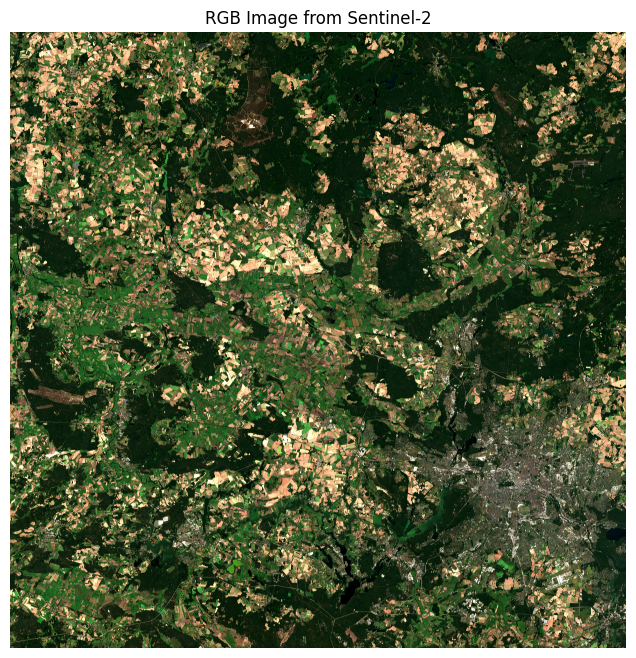

In [9]:
# Stack bands and normalize to [0, 1] for display
rgb = np.stack([red, green, blue], axis=-1).astype(np.float32)
rgb_min, rgb_max = np.percentile(rgb, (2, 98))
rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.axis('off')
plt.title("RGB Image from Sentinel-2")
plt.show()

##### NIR e NDVI
Spettro Near InfraRed e Normalized Difference Vegetation Index (NDVI) per individuare la vegetazione

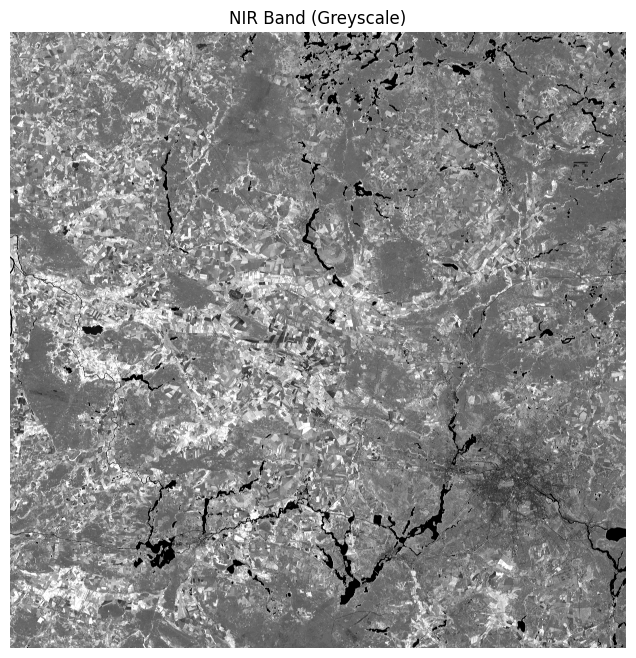

In [10]:
# Display the NIR (Near Infrared) band as a greyscale image
nir_min, nir_max = np.percentile(nir, (2, 98))
nir_norm = np.clip((nir - nir_min) / (nir_max - nir_min), 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(nir_norm, cmap='gray')
plt.axis('off')
plt.title("NIR Band (Greyscale)")
plt.show()

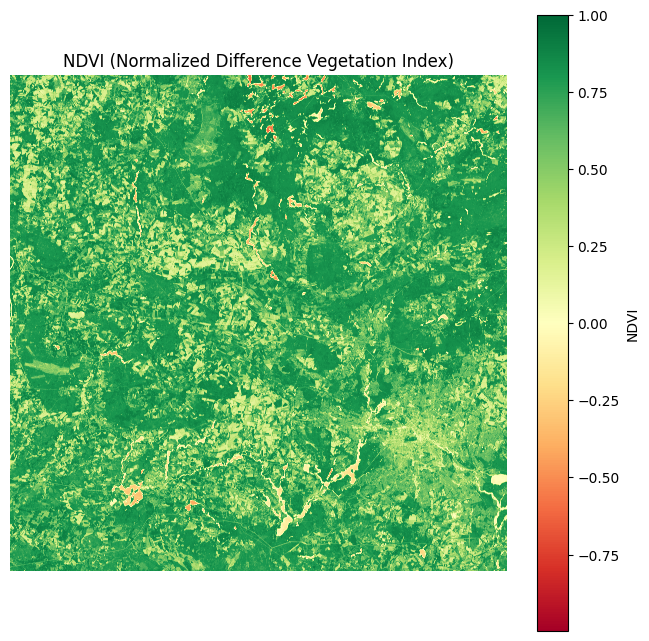

In [11]:
# NDVI calculation: (NIR - Red) / (NIR + Red)
ndvi = (nir - red) / (nir + red + 1e-10)  # Add small constant to avoid division by zero
ndvi = np.clip(ndvi, -1, 1)  # NDVI is typically in [-1, 1]

plt.figure(figsize=(8, 8))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.axis('off')
plt.title("NDVI (Normalized Difference Vegetation Index)")
plt.show()

##### Water 
Normalized Difference Water Index

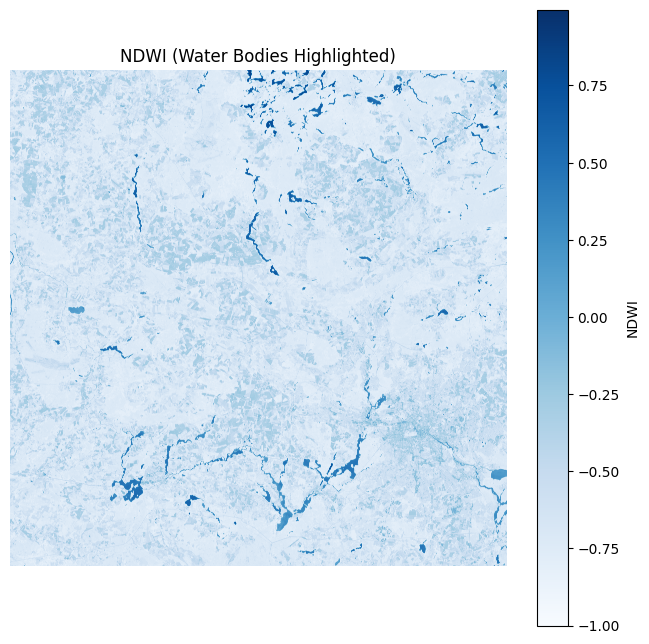

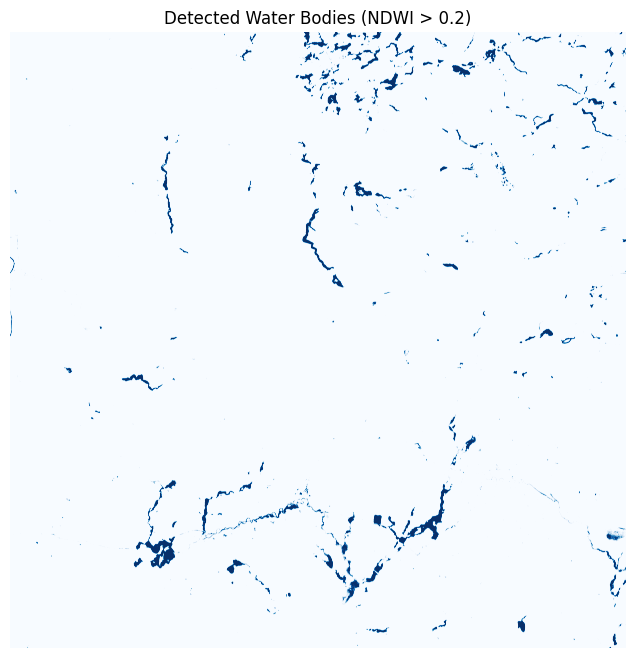

In [12]:
# Water detection using NDWI (Normalized Difference Water Index)
# NDWI = (Green - NIR) / (Green + NIR)
ndwi = (green.astype(np.float32) - nir) / (green.astype(np.float32) + nir + 1e-10)
ndwi = np.clip(ndwi, -1, 1)

plt.figure(figsize=(8, 8))
plt.imshow(ndwi, cmap='Blues')
plt.colorbar(label='NDWI')
plt.axis('off')
plt.title("NDWI (Water Bodies Highlighted)")
plt.show()

# Optional: Create a water mask (NDWI > 0.2 is a common threshold)
water_mask = ndwi > 0.2
plt.figure(figsize=(8, 8))
plt.imshow(water_mask, cmap='Blues')
plt.axis('off')
plt.title("Detected Water Bodies (NDWI > 0.2)")
plt.show()

##### Urban

In [13]:
# Le scene sono dei numeri interi che rappresentano le classi di classificazione (e.g., vegetazione, acqua, nuvole))
np.unique(scene)

array([ 0,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8)

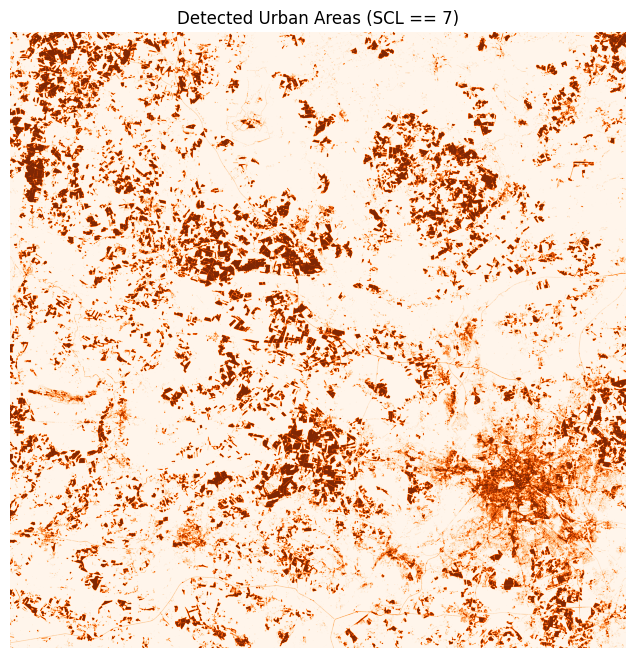

In [14]:
# Urban areas can be identified using the Scene Classification Layer (SCL)
# In Sentinel-2 SCL, class 5 corresponds to "bare soil", di solito legato a aree urbane

urban_mask = scene == 5

plt.figure(figsize=(8, 8))
plt.imshow(urban_mask, cmap='Oranges')
plt.axis('off')
plt.title("Detected Urban Areas (SCL == 7)")
plt.show()

### Confronto temporale
Esempio - Confrontiamo la variazione in termini di NDVI (indice vegetazione), per la stessa area in due date diverse.

Nota -  Le immagini sono 'tagliate' (pixel azzerati) per la presenza di nuvole.

In [16]:
# Define Area of Interest (bounding box)
aoi = box(13.39, 52.50, 13.43, 52.51)  # Berlin (Lon/Lat)

# Define Date Inrerval
start_date = "2023-07-01"
end_date   = "2025-05-10"

# Search parameters
results = catalog.search(
    collections = ["sentinel-2-l2a"],
    intersects = aoi,
    datetime = start_date + "/" + end_date,
    query = {"eo:cloud_cover": {"lt": 10}})


items = list(results.items())

In [17]:
print("Newest Element Found: ", items[0].id, items[0].datetime)
print("Oldest Element Found: ", items[-4].id, items[-4].datetime)

Newest Element Found:  S2C_32UQD_20250502_0_L2A 2025-05-02 10:16:35.379000+00:00
Oldest Element Found:  S2A_32UQD_20230910_0_L2A 2023-09-10 10:16:18.873000+00:00


red band shape: (10980, 10980)
nir band shape: (10980, 10980)
red band shape: (10980, 10980)
nir band shape: (10980, 10980)


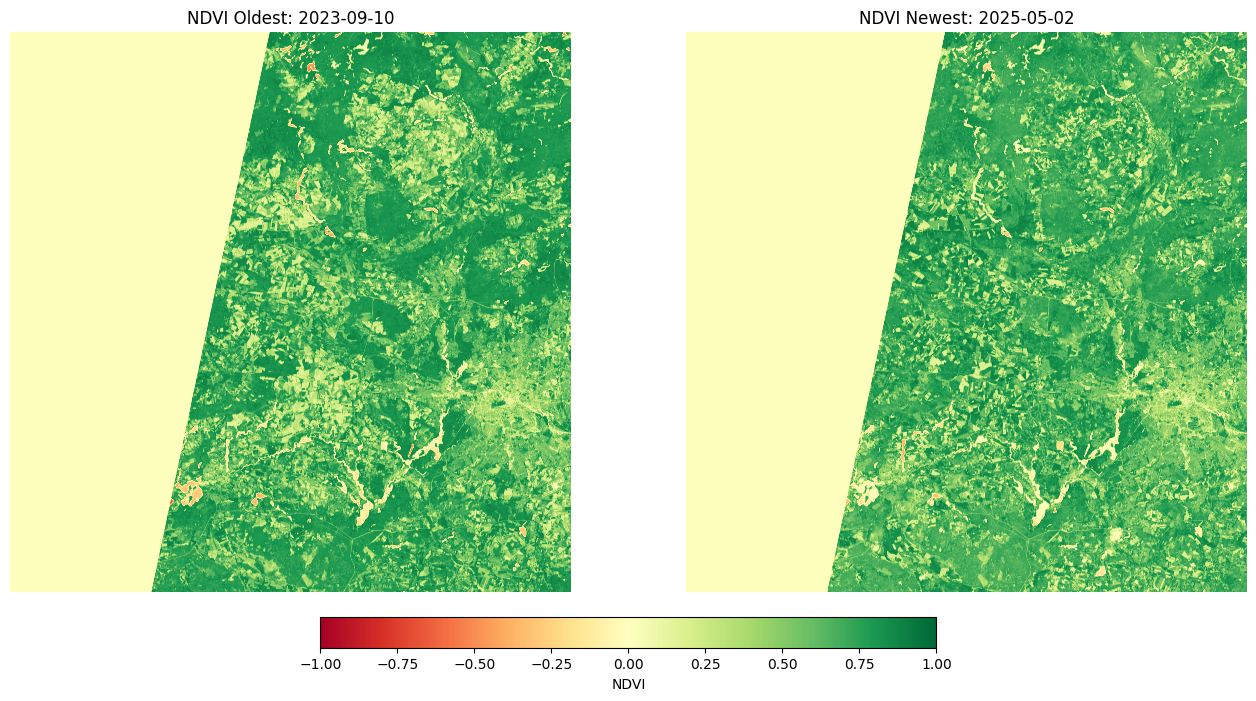

In [18]:
# Get newest and oldest items
item_newest = items[0]
item_oldest = items[-4]

# Download red and nir bands for both dates
red_new = raster_downloader(item_newest, "red")
nir_new = raster_downloader(item_newest, "nir")
red_old = raster_downloader(item_oldest, "red")
nir_old = raster_downloader(item_oldest, "nir")

# Compute NDVI for both dates
ndvi_new = (nir_new - red_new) / (nir_new + red_new + 1e-10)
ndvi_new = np.clip(ndvi_new, -1, 1)
ndvi_old = (nir_old - red_old) / (nir_old + red_old + 1e-10)
ndvi_old = np.clip(ndvi_old, -1, 1)

# Plot comparison
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
im0 = axs[0].imshow(ndvi_old, cmap='RdYlGn', vmin=-1, vmax=1)
axs[0].set_title(f"NDVI Oldest: {item_oldest.datetime.date()}")
axs[0].axis('off')
im1 = axs[1].imshow(ndvi_new, cmap='RdYlGn', vmin=-1, vmax=1)
axs[1].set_title(f"NDVI Newest: {item_newest.datetime.date()}")
axs[1].axis('off')
fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, label='NDVI')
plt.show()

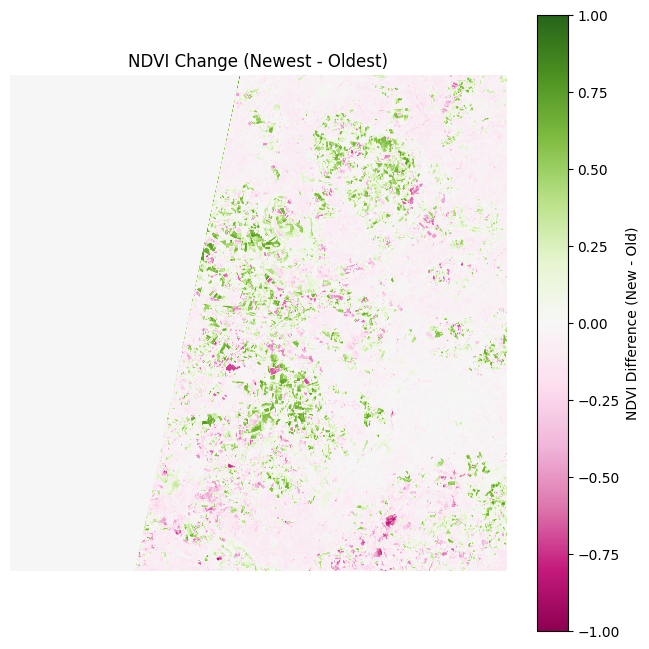

In [19]:
# Calculate the difference between the two NDVI maps (newest - oldest)
ndvi_diff = ndvi_new - ndvi_old

plt.figure(figsize=(8, 8))
plt.imshow(ndvi_diff, cmap='PiYG', vmin=-1, vmax=1)
plt.colorbar(label='NDVI Difference (New - Old)')
plt.axis('off')
plt.title("NDVI Change (Newest - Oldest)")
plt.show()

# LLM and RAG

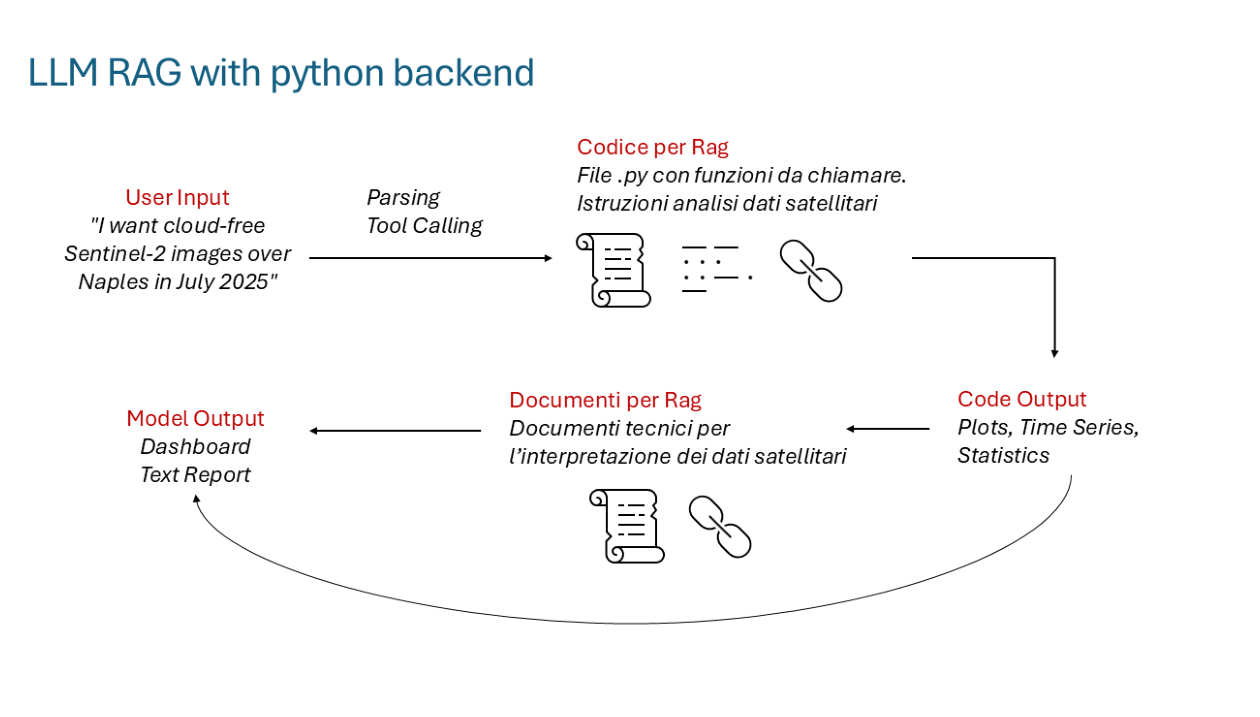

In [ ]:
'''
# Show png in c:\Users\diesi\OneDrive\Documents\LATITUDO\LLM RAG with python backend.png
import matplotlib.image as mpimg
img = mpimg.imread(r'c:\Users\diesi\OneDrive\Documents\LATITUDO\LLM RAG with python backend.png')
plt.figure(figsize=(16, 10))
plt.imshow(img)
plt.axis('off')
plt.show()
'''

# Cool Tool

### Geocoding

In [1]:
from geopy.geocoders import Nominatim
from shapely.geometry import box

def geocode_to_bbox(location: str, buffer_km: float = 5):
    geolocator = Nominatim(user_agent="sentinel-assistant")
    loc = geolocator.geocode(location)
    if not loc:
        raise ValueError(f"Could not geocode location: {location}")
    lat, lon = loc.latitude, loc.longitude
    # Create a small box around the point (roughly 0.05 deg ~ 5 km)
    return (lon - 0.05, lat - 0.05, lon + 0.05, lat + 0.05)

In [4]:
geocode_to_bbox('Greenwich')

(-0.054541700000000005, 51.4320845, 0.0454583, 51.532084499999996)

In [17]:
import folium
from folium.plugins import Draw
from IPython.display import display

def interactive_bbox_map(center=(40.85, 14.26), zoom=10):
    m = folium.Map(location=center, zoom_start=zoom)
    draw = Draw(export=True, filename='bbox.json', draw_options={
        'polyline': False, 'circle': True, 'marker': False, 'circlemarker': False,
        'polygon': True, 'rectangle': True
    }, edit_options={'edit': False})
    draw.add_to(m)
    return m


In [18]:
m = interactive_bbox_map()
display(m)


In [7]:
import json

def geojson_to_bbox(geojson_path):
    with open(geojson_path) as f:
        gj = json.load(f)
    coords = gj['features'][0]['geometry']['coordinates'][0]
    lons, lats = zip(*coords)
    return min(lons), min(lats), max(lons), max(lats)


In [12]:
# Prepare path "C:\Users\diesi\Downloads\bbox.json"
geojson_to_bbox("C:\\Users\\diesi\\Downloads\\bbox.json")

(14.157006, 41.012267, 14.44392, 41.119884)